This kernel is continuation of BBC Document Classification problem. All the preprocessing and EDA was done In PART 1: [BBC Document Classification Part 1 - Preprocessing][1].

[1]: https://www.kaggle.com/code/dheemanthbhat/bbc-document-classification-part-1-preprocessing

## 1 Setup

### 1.1 Import and configure libraries

In [1]:
# Data manipulation libraries.
import numpy as np
import scipy as sp
from scipy.spatial import distance
import pandas as pd

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable


# Data modeling libraries.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils, Input, callbacks
from tensorflow.keras.layers import Conv1D, Dense, Embedding, Flatten, MaxPool1D, Dropout

# General Imports
import os
import re
import math
import time
import shutil


# Library versions.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)

# Configure NumPy.
# Set precission to four decimal places.
# Set `Line width` to Maximum 130 characters in the output.
# Post 130 characters it will continue in the next line.
np.set_printoptions(precision=4, linewidth=130)

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.25)  # Set font to scale 1.25 more than normal.

# Configure Tensorflow.
tf.random.set_seed(100)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

NumPy version: 1.21.6
Pandas version: 1.3.5
Matplotlib version: 3.5.2
Seaborn version: 0.11.2
Scikit-learn version: 1.0.2
TensorFlow version: 2.6.4


### 1.2 Constants and Helper Functions

#### Constants

In [2]:
INPUT_CSV = "../input/bbc-full-text-preprocessed/docs_stage_3_preprocessed.csv"
GLOVE_TXT = "../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt"

LOGS_DIR = "../logs"
MODELS_DIR = "../models"
MODEL_FILE = "../models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.hdf5"


CLASS_COUNT = 5  # Class-label count.
OUTPUT_DIM = 100  # Word embedding output dimension.

# Epochs limit for EarlyStopping.
# Number of epochs with no improvement after which training will be stopped.
PATIENCE = 3

# Class-label mapping obtained from `BBC Document Classification Part 1` kernel.
cls_map = {"Business": 0, "Entertainment": 1, "Politics": 2, "Sport": 3, "Tech": 4}

#### Helper functions

In [3]:
def show_n_vals(row, n=5):
    """
    Function to shrink a `row` by showing ellipsis between
    first `n` values and last `n` values separated by coma.
    """
    if row is None:
        return "[]"

    lhs = []
    rhs = []
    for idx, val in enumerate(row):
        if idx < n:
            lhs.append(str(val))
        elif idx >= (len(row) - n):
            rhs.append(str(val))

    lhs = ", ".join(lhs)
    delim = ", ..." if len(row) > 2 * n else ""
    rhs = f", {', '.join(rhs)}" if len(rhs) else ""

    return f"[{lhs + delim + rhs}]"


# Lambda function to reduce input `value` by `percent` percentage.
reduce_by = lambda value, percent: value - (percent * value / 100)


def cosine_sim(gvec_index, word1, word2):
    """
    Function to compute cosine-similarity between
    two input words based on their GloVe vectors.
    """
    vec1 = gvec_index.get(word1.lower())
    print(f"GloVe vector for `{word1}`: {show_n_vals(vec1, 3)}")

    vec2 = gvec_index.get(word2.lower())
    print(f"GloVe vector for `{word2}`: {show_n_vals(vec2, 3)}")

    c_dist = distance.cosine(vec1, vec2)
    print(f"Cosine similarity between '{word1}' and '{word2}': {round(c_dist, 4)}")

### 1.3 Reset Directories

Remove logs and saved models from previous run.

In [4]:
shutil.rmtree(LOGS_DIR, ignore_errors=True)
shutil.rmtree(MODELS_DIR, ignore_errors=True)

### 1.4 Load Dataset

In [5]:
docs_df = pd.read_csv(INPUT_CSV)
docs_df.head(3)

,DocId,DocTextlen,DocText,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,...,PUNCT,SCONJ,SYM,VERB,X,INTJ,DocType,FileSize,FilePath,DocCat
0,B_001,2553,ad sale boost time_warner profit quarterly pro...,31,61,15.0,15.0,13.0,28,114,...,55,3.0,9.0,53,0.0,0.0,Business,2560,../input/bbc-full-text-document-classification...,0
1,B_002,2248,dollar gain greenspan speech dollar hit high l...,33,54,15.0,21.0,9.0,44,99,...,43,5.0,2.0,43,0.0,0.0,Business,2252,../input/bbc-full-text-document-classification...,0
2,B_003,1547,yukos unit buyer face loan claim owner embattl...,11,32,3.0,15.0,4.0,25,71,...,26,3.0,4.0,42,0.0,0.0,Business,1552,../input/bbc-full-text-document-classification...,0


## 2 EDA

In [6]:
rows, cols = docs_df.shape
print(f"Dataset contains {rows} rows and {cols} columns.\n")

docs_df.info()

Dataset contains 2205 rows and 24 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DocId       2205 non-null   object 
 1   DocTextlen  2205 non-null   int64  
 2   DocText     2205 non-null   object 
 3   ADJ         2205 non-null   int64  
 4   ADP         2205 non-null   int64  
 5   ADV         2205 non-null   float64
 6   AUX         2205 non-null   float64
 7   CCONJ       2205 non-null   float64
 8   DET         2205 non-null   int64  
 9   NOUN        2205 non-null   int64  
 10  NUM         2205 non-null   float64
 11  PART        2205 non-null   float64
 12  PRON        2205 non-null   float64
 13  PROPN       2205 non-null   int64  
 14  PUNCT       2205 non-null   int64  
 15  SCONJ       2205 non-null   float64
 16  SYM         2205 non-null   float64
 17  VERB        2205 non-null   int64  
 18  X           2205 non-nul

#### Observation

1. Input features `DocText` is not missing any data, i.e., Non-Null count matches with row count.
1. Target class-label `DocCat` is not missing any data, i.e., Non-Null count matches with row count.

> **Note**: For complete EDA refer PART 1: [BBC Document Classification Part 1 - Preprocessing][1].

[1]: https://www.kaggle.com/code/dheemanthbhat/bbc-document-classification-part-1-preprocessing

## 3 Feature Engineering

### 3.1 Tokenization

Input data should be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the `Tokenizer` API provided in Keras library.

Ref: [Tokenization and Text Data Preparation with TensorFlow & Keras][1]

[1]: https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

#### Tokenizer

In [7]:
tokenizer = Tokenizer(
    num_words=5000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',  # Underscore character removed.
    oov_token="<UNK>",  # Out-of-vocabulary token.
)

tokenizer.fit_on_texts(docs_df["DocText"].values)

#### Word Index

In [8]:
word_index = tokenizer.word_index
vocab_size = len(word_index)  # Word vocabulary size.

print("Total words in vocabulary:", vocab_size)
print("\nSample word index:")
{k: v for k, v in list(word_index.items())[:10]}

Total words in vocabulary: 29397

Sample word index:


{'<UNK>': 1,
 'say': 2,
 'year': 3,
 'mr': 4,
 'people': 5,
 'new': 6,
 'm': 7,
 'time': 8,
 'good': 9,
 'win': 10}

#### Sequencing

In [9]:
# Encode documents into sequences.
en_docs = tokenizer.texts_to_sequences(docs_df["DocText"].values)

print("Sequences:")
print("Data type:", type(en_docs))
print("Total count:", len(en_docs))
print("Sample values:")
_ = [print(show_n_vals(row)) for row in en_docs[:3]]

Sequences:
Data type: <class 'list'>
Total count: 2205
Sample values:
[1938, 47, 376, 1, 256, ..., 849, 1, 604, 460, 849]
[264, 616, 4310, 617, 264, ..., 162, 200, 119, 1458, 264]
[433, 659, 1561, 99, 982, ..., 3138, 2451, 1018, 4568, 47]


In [10]:
seq_lengths = [len(x) for x in en_docs]

# Get max training sequence length.
max_len = max(seq_lengths)
print("Longest sequence is of length:", max_len)

# Get max training sequence length.
min_len = min(seq_lengths)
print("Shortest sequence is of length:", min_len)

Longest sequence is of length: 572
Shortest sequence is of length: 41


#### Which is the best value for sequence length?

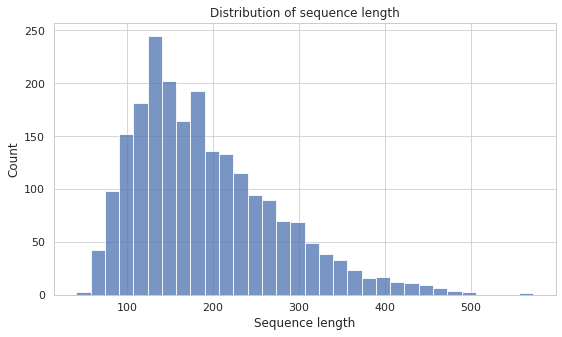

In [11]:
plt.figure(figsize=(9, 5))

sns.histplot(x=seq_lengths)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Distribution of sequence length")

plt.show()

#### Pick sequence length based on elbow method

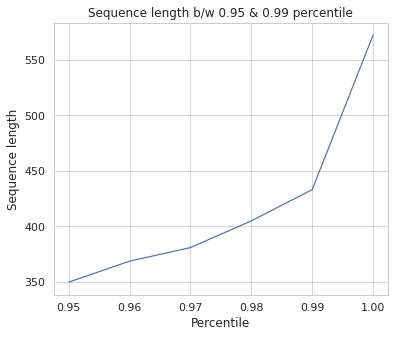

In [12]:
ll, hl = 0.95, 1
plt.figure(figsize=(6, 5))

x = np.arange(ll, hl, 0.01)
y = np.quantile(a=np.array(seq_lengths), q=x)

sns.lineplot(x=x, y=y)
plt.title(f"Sequence length b/w {ll} & {round(hl - 0.01, 2)} percentile")
plt.xlabel("Percentile")
plt.ylabel("Sequence length")

plt.show()

#### Observations

~99% of documents have sequence length less than 450, hence pick this value for `seq_len`.

In [13]:
seq_len = 450

### 3.2 Padding

In [14]:
pad_docs = pad_sequences(en_docs, maxlen=seq_len, padding="post", truncating="post")

print("Padded sequences:")
print("Data type:", type(pad_docs), "Shape:", pad_docs.shape)
print("Sample values:")
print(pad_docs)

Padded sequences:
Data type: <class 'numpy.ndarray'> Shape: (2205, 450)
Sample values:
[[1938   47  376 ...    0    0    0]
 [ 264  616 4310 ...    0    0    0]
 [ 433  659 1561 ...    0    0    0]
 ...
 [ 751  400  240 ...    0    0    0]
 [ 716  279  260 ...    0    0    0]
 [3538  222  118 ...    0    0    0]]


### 3.3 GloVe Vectors

#### Load vector representation of words

In [15]:
%%time

# load the whole embedding.
gvec_index = dict()
with open(GLOVE_TXT, encoding="utf8") as txt_f:
    for line in txt_f.readlines():
        columns = line.split()
        wrd = columns[0]
        vec = np.array(columns[1:], dtype="float32")
        gvec_index[wrd] = vec

CPU times: user 8.85 s, sys: 1.09 s, total: 9.94 s
Wall time: 15.4 s


In [16]:
print("Total number of words in GloVe index:", len(gvec_index.keys()))
print("Sample word vectors:")

table = PrettyTable(["Word", "Pre trained vectors"], align="l")
table.add_rows([[k, show_n_vals(v, n=3)] for k, v in list(gvec_index.items())[:5]])

print(table)

Total number of words in GloVe index: 400000
Sample word vectors:
+------+-----------------------------------------------------------------+
| Word | Pre trained vectors                                             |
+------+-----------------------------------------------------------------+
| the  | [-0.038194, -0.24487, 0.72812, ..., -0.1459, 0.8278, 0.27062]   |
| ,    | [-0.10767, 0.11053, 0.59812, ..., -0.83155, 0.45293, 0.082577]  |
| .    | [-0.33979, 0.20941, 0.46348, ..., -0.23394, 0.47298, -0.028803] |
| of   | [-0.1529, -0.24279, 0.89837, ..., -0.591, 1.0039, 0.20664]      |
| to   | [-0.1897, 0.050024, 0.19084, ..., -0.39804, 0.47647, -0.15983]  |
+------+-----------------------------------------------------------------+


#### Missing words

In [17]:
missing_words = [wrd for wrd in word_index.keys() if wrd not in gvec_index.keys()]
misc = len(missing_words)
misp = round(misc / len(word_index.keys()) * 100, 1)
print(f"{misc} i.e., {misp}% words in our vocabulary does not have GloVe vectors.")

10876 i.e., 37.0% words in our vocabulary does not have GloVe vectors.


#### Load weights

In [18]:
# All zero valued vector.
zero_vec = np.zeros(OUTPUT_DIM)

weights = [zero_vec]  # For <PAD>

# Create a weight matrix for words in vocabulary.
for word in word_index.keys():
    weights.append(gvec_index.get(word, zero_vec).tolist())


weights = tf.convert_to_tensor(weights, dtype=tf.float32)
print("Weights datatype:", weights.dtype)
print("Weights shape:", weights.shape)

Weights datatype: <dtype: 'float32'>
Weights shape: (29398, 100)


### 3.4 Cosine Similarity

1. GloVe has weights for both **American English** and **British English** words.
2. All the words in GloVe are is **lowercase**.
3. Cosine similarity **range b/w 0 and 1**. 
4. **Zero indicates least distance** (or highest similarity) and **one indicates maximum distance** (or lowest similarity).

#### Example 1: American English vs British English (Color vs Colour)

In [19]:
cosine_sim(gvec_index, "Color", "Colour")

GloVe vector for `Color`: [-0.52516, 0.44118, -0.1273, ..., -0.88581, 0.075446, 0.040447]
GloVe vector for `Colour`: [-0.87662, 0.21689, -0.32172, ..., -0.53163, 0.0032544, -0.19457]
Cosine similarity between 'Color' and 'Colour': 0.1234


#### Example 2: Dissimilar words (Pasta vs Lithium)

In [20]:
cosine_sim(gvec_index, "Pasta", "Lithium")

GloVe vector for `Pasta`: [-0.64703, 1.0037, -0.5975, ..., -0.31967, 0.84029, 0.82538]
GloVe vector for `Lithium`: [-1.1081, 0.90199, 0.34528, ..., -0.86303, 0.73829, -0.24633]
Cosine similarity between 'Pasta' and 'Lithium': 0.9128


### 3.5 POS features

Count of parts-of-speech in the document. Include these features along with padded sequences as input to he network.

In [21]:
docs_df.iloc[:, 3:18].astype("int32").head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB
0,31,61,15,15,13,28,114,27,14,27,36,55,3,9,53
1,33,54,15,21,9,44,99,5,14,12,27,43,5,2,43
2,11,32,3,15,4,25,71,5,13,15,29,26,3,4,42
3,36,53,16,17,8,26,114,34,13,17,34,62,8,10,45
4,15,32,5,13,8,14,68,15,10,10,41,35,5,3,26


## 4 Custom Callbacks

### 4.1 Callback #1: `PerformanceMetrics`

Callback to compute and print micro F1 score of validation dataset.

In [22]:
class PerformanceMetrics(callbacks.Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        cl_prob = self.model.predict(self.X_test)
        y_pred = np.argmax(cl_prob, axis=1)

        f1_scr = f1_score(self.y_test, y_pred, average="micro")
        print("Validation dataset F1-score:", round(f1_scr, 4))

### 4.2 Callback #2: `SaveBetterModel`

Callback to save model at every epoch if the validation accuracy improves compared to previous epoch.

In [23]:
class SaveBetterModel(callbacks.ModelCheckpoint):
    def __init__(self, **kwargs):
        super().__init__(
            monitor="val_accuracy",
            verbose=2,
            save_best_only=True,
            mode="max",
            **kwargs,
        )

    def on_epoch_end(self, epoch, logs=None):
        # To stop propagation of callbacks.
        if self.model.stop_training:
            return

        super().on_epoch_end(epoch, logs)

### 4.3 Callback #3: `TerminateWhenNaN`

Terminate training if loss is invalid (NaN or infinity).

In [24]:
class TerminateWhenNaN(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        # Validate loss for NaN values.
        loss = logs.get("loss")
        if (loss is not None) and (np.isnan(loss) or np.isinf(loss)):
            print("Invalid loss hence terminated at epoch:", epoch)
            # Inform next callback to skip execution.
            self.model.stop_training = True
            return

### 4.4 Callback #4: `DecayLearningRate`

1. Reduce learning rate by 10% if validation accuracy from current epoch is less than that of previous epoch.
2. Reduce learning rate by 5% every 3rd epoch.

In [25]:
class DecayLearningRate(callbacks.Callback):
    def __init__(self):
        self.prev_val_acc = 0  # previous validation accuracy.

    def __get_lr__(self):
        return float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

    def __set_lr__(self, new_lr):
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        curr_val_acc = logs.get("val_accuracy")
        lr = self.__get_lr__()
        if curr_val_acc < self.prev_val_acc:
            new_lr = reduce_by(lr, 10)
            self.__set_lr__(new_lr)
            print("Current epoch validation accuracy:", round(curr_val_acc, 4))
            print("Previous epoch validation accuracy:", round(self.prev_val_acc, 4))
            print("Reducing learning rate by 10%. New learning rate:", round(new_lr, 6))
        elif not (epoch + 1) % 3:
            # Since epochs start at zero, add one to get current epoch number.
            new_lr = reduce_by(lr, 5)
            self.__set_lr__(new_lr)
            print("Reducing learning rate by 5%. New learning rate:", round(new_lr, 6))

        # Save current validation accuracy value for next epoch.
        self.prev_val_acc = curr_val_acc

### 4.5 Callback #5: `TerminateOnNoChange`

**Early stopping:** Stop training when a validation accuracy has stopped improving.

In [26]:
class TerminateOnNoChange(callbacks.EarlyStopping):
    def __init__(self, epochs):
        super().__init__(monitor="val_accuracy", patience=epochs, verbose=2, mode="max")

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        super().on_epoch_end(epoch, logs)

## 5 Training Setup

### 5.1 Train, Test split

#### Train, Cval, Test split

In [27]:
X = np.column_stack((pad_docs, docs_df.iloc[:, 3:18].astype("int32")))
y = docs_df["DocCat"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train, X_cval, y_train, y_cval = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=42,
)

print("X train dataset:", X_train.shape)
print("y train dataset:", y_train.shape)

print("X cross-validation dataset:", X_cval.shape)
print("y cross-validation dataset:", y_cval.shape)

print("X test dataset:", X_test.shape)
print("y test dataset:", y_test.shape)

X train dataset: (1157, 465)
y train dataset: (1157,)
X cross-validation dataset: (496, 465)
y cross-validation dataset: (496,)
X test dataset: (552, 465)
y test dataset: (552,)


### 5.2 Scaling

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [29]:
sX_train = scaler.transform(X_train)  # Scaled X_train.
sX_cval = scaler.transform(X_cval)  # Scaled X_cval.
sX_test = scaler.transform(X_test)  # Scaled X_test.

print("X train scaled (random sample):")
print(np.round(sX_train[900:903], 3))

print("\nX cross-val scaled (random sample):")
print(np.round(sX_cval[354:357], 3))

print("\nX test scaled (random sample):")
print(np.round(sX_test[274:277], 3))

X train scaled (random sample):
[[-0.406 -0.374 -0.073 ... -0.939 -0.546 -0.353]
 [ 0.648 -0.655 -0.728 ... -0.339  1.474 -1.014]
 [-0.167  0.105  0.42  ...  0.46  -0.546  0.764]]

X cross-val scaled (random sample):
[[-0.696 -0.746 -0.785 ...  0.06  -0.546 -0.27 ]
 [ 0.035 -0.04   0.698 ... -0.739 -0.546 -1.138]
 [-0.024 -0.402 -0.576 ... -1.138  1.474 -1.262]]

X test scaled (random sample):
[[ 0.944 -0.672 -0.239 ... -1.338 -0.546 -0.642]
 [ 0.951  2.67   1.176 ...  0.46   1.474  0.598]
 [-0.397 -0.655 -0.385 ... -0.339 -0.546  0.143]]


> **Note: <font color="red">Scaling is not used since it did not show increase in accuracy beyond 35%.</font>**

### 5.3 Reshape Training Data

#### Expand dimensions of datasets

> **Note:** To enable scaling just replace `X_train`, `X_cval` and `X_test` in below code with `sX_train`, `sX_cval` and `sX_test`.

In [30]:
eX_train = np.expand_dims(X_train, axis=2)  # Expanded X_train.
eX_cval = np.expand_dims(X_cval, axis=2)  # Expanded X_cval.
eX_test = np.expand_dims(X_test, axis=2)  # Expanded X_test.

print("Expanded X train dataset:", eX_train.shape)
print("Expanded X cross-validation dataset:", eX_cval.shape)
print("Expanded X test dataset:", eX_test.shape)

Expanded X train dataset: (1157, 465, 1)
Expanded X cross-validation dataset: (496, 465, 1)
Expanded X test dataset: (552, 465, 1)


## 6 Modeling

In [31]:
# Reset all state generated by Keras.
tf.keras.backend.clear_session()

### 6.1 Define Model Architecture

Ref: [How to have parallel convolutional layers in keras?][1]

[1]: https://stackoverflow.com/a/45304179/5070460

In [32]:
rows, cols = X_train.shape

# Input Layer
inputs = Input(shape=(cols,), name="Input_Text")

# Embedding Layer.
x = Embedding(
    vocab_size + 1,
    OUTPUT_DIM,
    input_length=cols,
    name="EmbeddingLayer1",
    weights=[weights],
    trainable=False,
)(inputs)

# Three parallel Convolution layers with different filter size + Max pooling.
m = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_M_Filters")(x)
n = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_N_Filters")(x)
o = Conv1D(16, 3, padding="same", activation="relu", name="Conv1D_O_Filters")(x)
mno = tf.keras.layers.concatenate([m, n, o], name="Concatenate1_MNO")
x = MaxPool1D(3, name="MaxPoolLayer1")(mno)

# Three parallel Convolution layers with different filter size + Max pooling.
i = Conv1D(2, 3, padding="same", activation="relu", name="Conv1D_I_Filters")(x)
j = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_J_Filters")(x)
k = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_K_Filters")(x)
ijk = tf.keras.layers.concatenate([i, j, k], name="Concatenate2_IJK")
x = MaxPool1D(3, name="MaxPoolLayer2")(ijk)

x = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_P_Filters")(x)
x = Flatten(name="Flatten")(x)
x = Dropout(0.25, name="DropOut")(x)
x = Dense(30, activation="relu", name="Dense1")(x)

outputs = Dense(CLASS_COUNT, activation="softmax", name="Output_layer")(x)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs, name="Document_Classifier")
model1.summary()

Model: "Document_Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Text (InputLayer)         [(None, 465)]        0                                            
__________________________________________________________________________________________________
EmbeddingLayer1 (Embedding)     (None, 465, 100)     2939800     Input_Text[0][0]                 
__________________________________________________________________________________________________
Conv1D_M_Filters (Conv1D)       (None, 465, 4)       1204        EmbeddingLayer1[0][0]            
__________________________________________________________________________________________________
Conv1D_N_Filters (Conv1D)       (None, 465, 8)       2408        EmbeddingLayer1[0][0]            
________________________________________________________________________________

### 6.2 Display Model Architecture

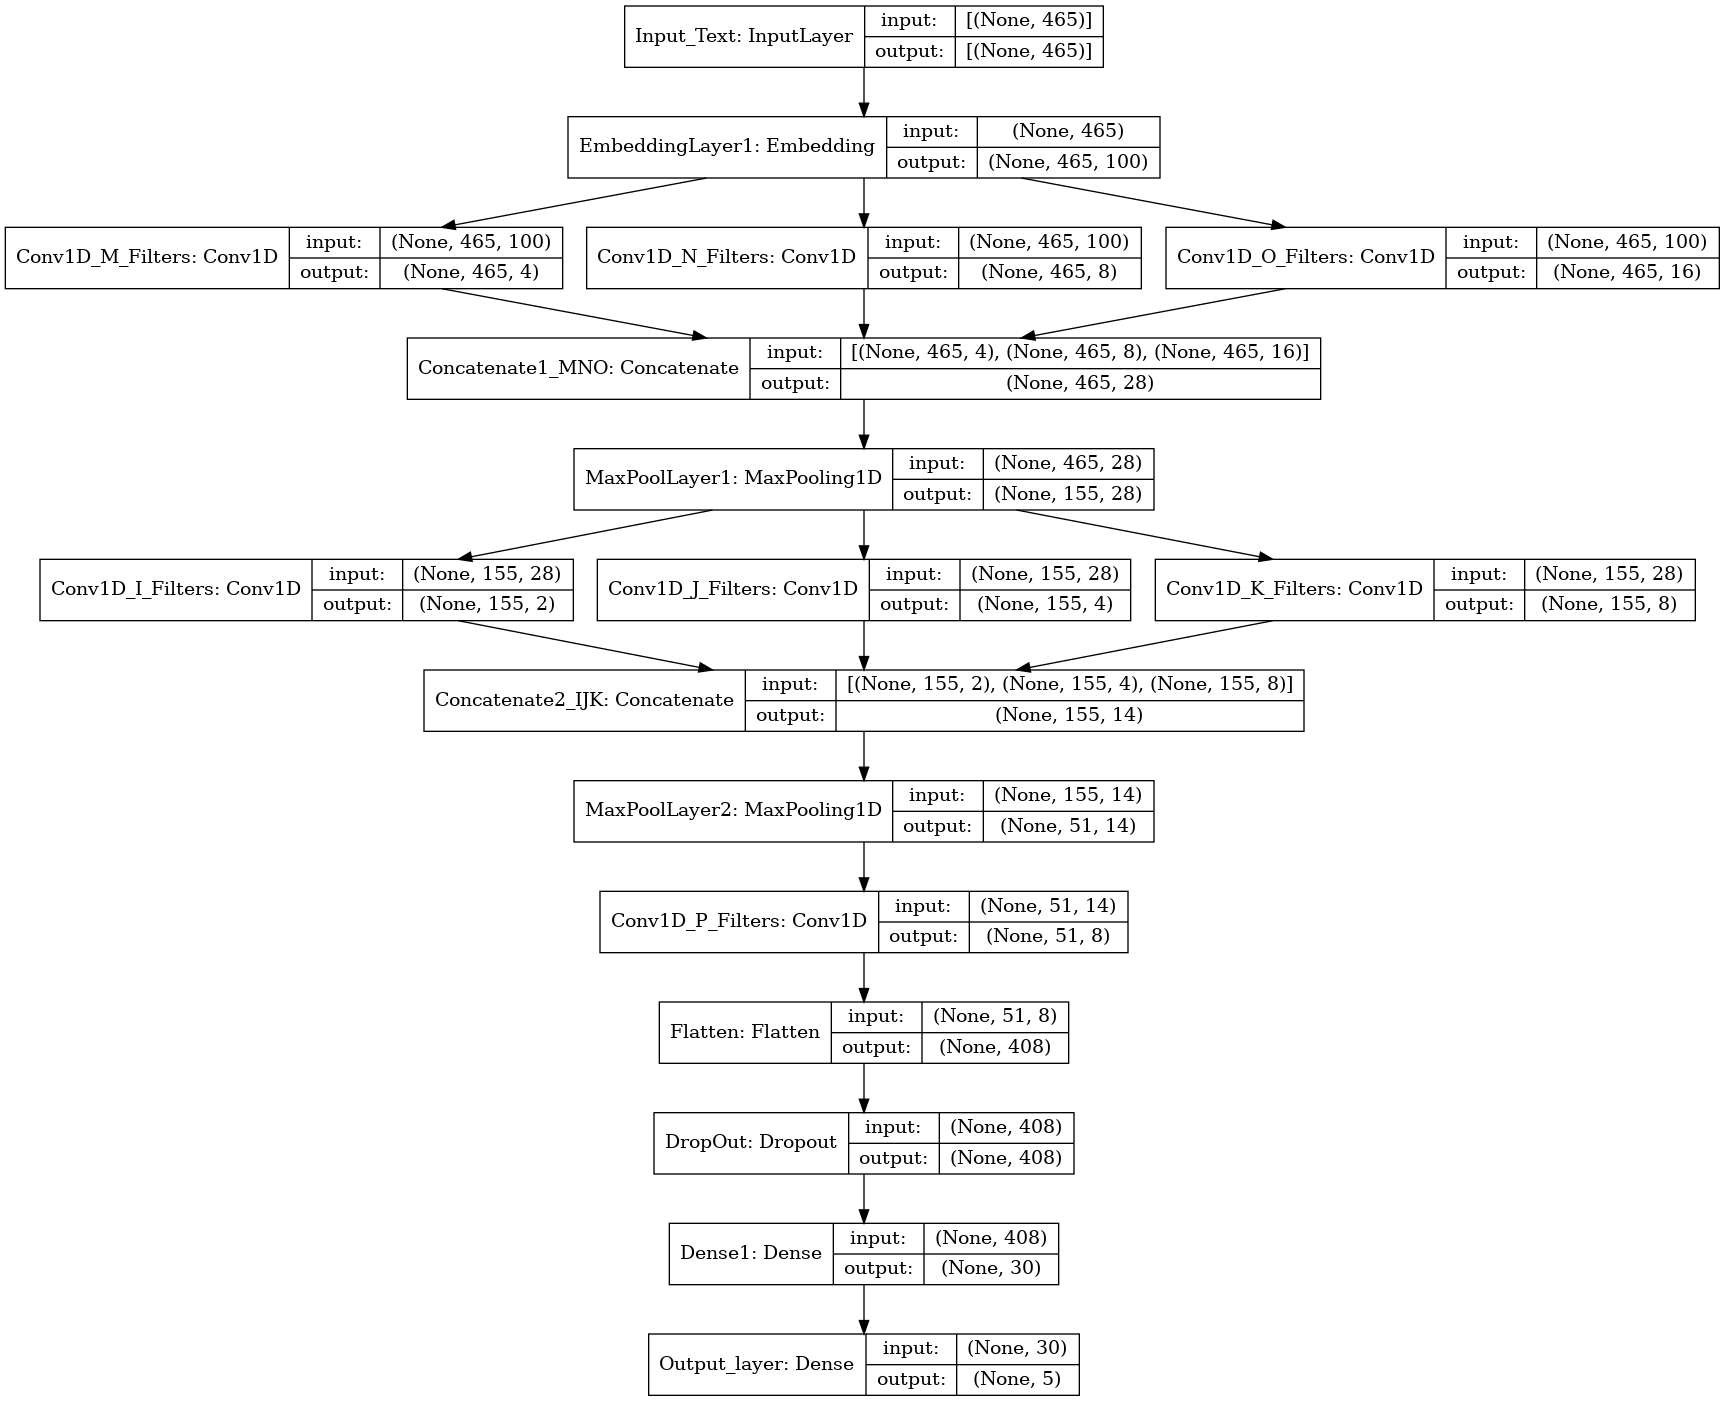

In [33]:
utils.plot_model(model1, "Document_Classification_Model.png", show_shapes=True)

### 6.3 Compile Model

#### Why `sparse_categorical_crossentropy` as loss function?

If targets are one-hot encoded, use `categorical_crossentropy` else if they are list of integers use `sparse_categorical_crossentropy`.

Ref: https://datascience.stackexchange.com/a/55987/103781

In [34]:
model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.002),
    metrics=["accuracy"],
)

### 6.4 Train Model

#### Handle Imbalanced dataset

In [35]:
cls_weights = {}
for cls, count in y_train.value_counts().sort_index().iteritems():
    cls_weights[cls] = round(1 - (count / len(y_train)), 2)  # Logic 1
    # cls_weights[cls] = (1 / count) * (len(y_train) / 2.0)  # Logic 2

print("Class weights:", cls_weights)

Class weights: {0: 0.77, 1: 0.83, 2: 0.81, 3: 0.77, 4: 0.82}


> **Note:** 
> 1. Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. 
> 2. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD()`, may fail. 
> 3. The optimizer used here, `tf.keras.optimizers.Adam()`, is unaffected by the scaling change.

Ref: tensorflow.org:[Classification on imbalanced data][1]

[1]: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

#### Fit

In [36]:
_ = model1.fit(
    x=eX_train,
    y=y_train,
    batch_size=89,
    epochs=15,
    verbose=2,
    callbacks=[
        callbacks.TensorBoard(LOGS_DIR, histogram_freq=1),
        TerminateWhenNaN(),
        PerformanceMetrics(eX_cval, y_cval),
        DecayLearningRate(),
        SaveBetterModel(filepath=MODEL_FILE),
        TerminateOnNoChange(epochs=PATIENCE),
    ],
    validation_data=(eX_cval, y_cval),
    # class_weight=cls_weights,
)

Epoch 1/15
13/13 - 3s - loss: 1.4940 - accuracy: 0.3224 - val_loss: 1.3106 - val_accuracy: 0.5444
Validation dataset F1-score: 0.5444

Epoch 00001: val_accuracy improved from -inf to 0.54435, saving model to ../models/epoch-01_accuracy-0.5444.hdf5
Epoch 2/15
13/13 - 1s - loss: 1.1379 - accuracy: 0.5523 - val_loss: 0.9447 - val_accuracy: 0.6210
Validation dataset F1-score: 0.621

Epoch 00002: val_accuracy improved from 0.54435 to 0.62097, saving model to ../models/epoch-02_accuracy-0.6210.hdf5
Epoch 3/15
13/13 - 1s - loss: 0.8452 - accuracy: 0.6785 - val_loss: 0.7224 - val_accuracy: 0.7016
Validation dataset F1-score: 0.7016
Reducing learning rate by 5%. New learning rate: 0.0019

Epoch 00003: val_accuracy improved from 0.62097 to 0.70161, saving model to ../models/epoch-03_accuracy-0.7016.hdf5
Epoch 4/15
13/13 - 1s - loss: 0.6325 - accuracy: 0.7623 - val_loss: 0.5663 - val_accuracy: 0.8044
Validation dataset F1-score: 0.8044

Epoch 00004: val_accuracy improved from 0.70161 to 0.80444, 

### 6.5 TensorBoard

Load TensorBoard extension for Jupyter Notebook.

In [37]:
# %reload_ext tensorboard

In [38]:
# %tensorboard --logdir $LOGS_DIR

Since TensorBoard [has temporarily been disabled][1] in Kaggle kernels. Refer below screenshots for reference.

[1]: https://www.kaggle.com/product-feedback/89671#764494

![BBC Document classfication TensorBoard](https://i.imgur.com/lORfs4c.png)

#### Observations

1. Validation error reduced drastically up to 4 epochs and tapered off before early stopping.
2. There is **no huge difference** between train error and validation error, hence the model is **not overfitting**.

### 6.6 Validate Model

In [39]:
model1.evaluate(eX_test, y_test, verbose=2)

18/18 - 0s - loss: 0.1142 - accuracy: 0.9692


[0.11420385539531708, 0.9692028760910034]

#### Observations

1. Final loss: 0.11
2. Final accuracy: 0.97

> **Note:** [GloVe vectors dataset][1] used in this kernel is are not updated since 6 years. Validation error might reduce if [latest GloVe vectors][2] are used.

[1]: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
[2]: https://nlp.stanford.edu/projects/glove/

## 7 Performance Metrics

### 7.1 Confusion Matrix

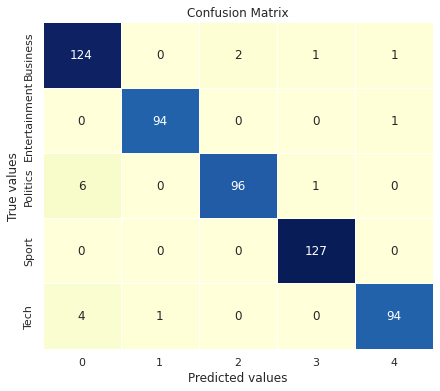

In [40]:
# Predict y_test class-labels
cl_prob = model1.predict(eX_test)
y_pred = np.argmax(cl_prob, axis=1)

# Compute confusion matrix
c_mat = tf.math.confusion_matrix(y_test, y_pred, CLASS_COUNT).numpy()

# Plot confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    c_mat,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=False,
    linecolor="white",
    linewidths=1,
    yticklabels=cls_map.keys(),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

#### Observations

1. 124 out of 128 (**97%**) documents were correctly predicted as _Business_ class.
2. 94 out of 95 (**99%**) documents were correctly predicted as _Entertainment_ class.
3. 96 out of 103 (**93%**) documents were correctly predicted as _Politics_ class.
4. 127 out of 127 (**100%**) documents were correctly predicted as _Sport_ class.
5. 94 out of 99 (**95%**) documents were correctly predicted as _Tech_ class.
6. Documents of class _Politics_ has **most number of wrong predictions**. 
7. Six documents related to politics are wrongly predicted as class _Business_.
8. Four documents related to technology are wrongly predicted as class _Business_.